In [1]:
#importing the Libraries that are required for the work
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras_tqdm import TQDMNotebookCallback


C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# loding the training image data and training labels
with open('train_image.pkl','rb') as f:
    train_data = pickle.load(f)
    
with open('train_label.pkl','rb') as f:
    train_label = pickle.load(f)


In [3]:
# loading the test data on which the prediction is to be done
with open('test_image.pkl','rb') as f:
    predict_data = pickle.load(f)
# checking the size of data to be predicted
length = len(predict_data)

In [4]:
# converting the label 6 to 1 so that it will be helpful for categorical encoding of labels
label = []
for x in train_label:
    if(x == 6):
        x = 1
    label.append(x)

In [5]:
# converting the data that is in list form to a numpy array for future comfort in the work 
train_data = np.array(train_data)    
label = np.array(label) 
predict_data = np.array(predict_data) 
   
# Defining some constraints for future use
img_rows, img_cols = 28, 28  # as image data is of 784 = 28*28
batch_size = 64
num_classes = 4
epochs = 40


In [6]:
# splitting the test and train data from the training dataset to check the accuracy of the model and visualize graph
# But the actually submitted csv file was trained on whole training dataset 
x_train, x_test , y_train , y_test = train_test_split(train_data, label, test_size = 0.15,random_state = 42)


In [14]:
# As the data given is flatenned initially so we need to reshape it to 28*28 so that we can apply CNN layers to the image dataset

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    predict_data = predict_data.reshape(predict_data.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    predict_data = predict_data.reshape(predict_data.shape[0], img_rows, img_cols,1)
    input_shape = (img_rows, img_cols, 1)
    
 

In [8]:
# Doing feature Scaling of the dataset so that all its values are between 0 and 1
# an orthodox method for improving accuracy
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
predict_data = predict_data.astype('float32')
x_train /= 255
x_test /= 255
predict_data /=255

In [9]:
# Categorical Encoding of Labels so that no label have more priority than the other
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [10]:
# Defining the neural network architecture proposed using 2 CNN layers 1 Maxpooling layer and 1 Dense layer 
# and the other layer is rthe output layer
# using Dropout to reduce overfitting
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
# used binary_crossentropy instead of categorical_crossentropy as it it seems on testing that the classes are somewhere related
# to each other so this give better results
model.compile(optimizer='Adadelta', loss='binary_crossentropy', metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [11]:
# using image augmentation to create a variety in training dataset for best results
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
# fitting the image augmentation to training dataset
datagen.fit(x_train) 
 

Train on 6392 samples, validate on 408 samples
Epoch 1/40
 - 7s - loss: 0.3484 - acc: 0.8368 - val_loss: 0.2758 - val_acc: 0.8805
Epoch 2/40
 - 4s - loss: 0.2504 - acc: 0.8913 - val_loss: 0.2307 - val_acc: 0.9032
Epoch 3/40
 - 4s - loss: 0.2111 - acc: 0.9114 - val_loss: 0.1965 - val_acc: 0.9167
Epoch 4/40
 - 4s - loss: 0.1908 - acc: 0.9192 - val_loss: 0.1885 - val_acc: 0.9246
Epoch 5/40
 - 4s - loss: 0.1733 - acc: 0.9248 - val_loss: 0.1767 - val_acc: 0.9259
Epoch 6/40
 - 4s - loss: 0.1628 - acc: 0.9332 - val_loss: 0.1748 - val_acc: 0.9308
Epoch 7/40
 - 4s - loss: 0.1526 - acc: 0.9358 - val_loss: 0.1953 - val_acc: 0.9216
Epoch 8/40
 - 4s - loss: 0.1448 - acc: 0.9411 - val_loss: 0.1768 - val_acc: 0.9246
Epoch 9/40
 - 4s - loss: 0.1354 - acc: 0.9436 - val_loss: 0.1666 - val_acc: 0.9387
Epoch 10/40
 - 4s - loss: 0.1272 - acc: 0.9487 - val_loss: 0.1638 - val_acc: 0.9301
Epoch 11/40
 - 4s - loss: 0.1182 - acc: 0.9528 - val_loss: 0.1637 - val_acc: 0.9314
Epoch 12/40
 - 4s - loss: 0.1096 - acc

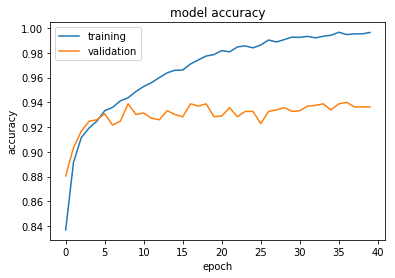


Test loss: 0.266
Test accuracy: 0.935


In [12]:
# fitting the proposed model to the dataset and visualizing the results and finding accuracy on validation set and test set  
history = model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs, validation_split=.06, verbose=2)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=0)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print()
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')


In [16]:
#now predicting the results for the given test data and saving it to a csv file
results = model.predict(predict_data)  
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="class")
# replacing the class having index 1 to 6 as its correct label is 6
result = results.replace(to_replace=1, value=6)

submission = pd.concat([pd.Series(range(0,length),name = "image_index"),result],axis = 1)

submission.to_csv("nitin.csv",index=False)
    